Correct slit coord input. End point is farther from the image center than the start point.
Rotated -239.03624346792648° in clockwise to make the slit upright.


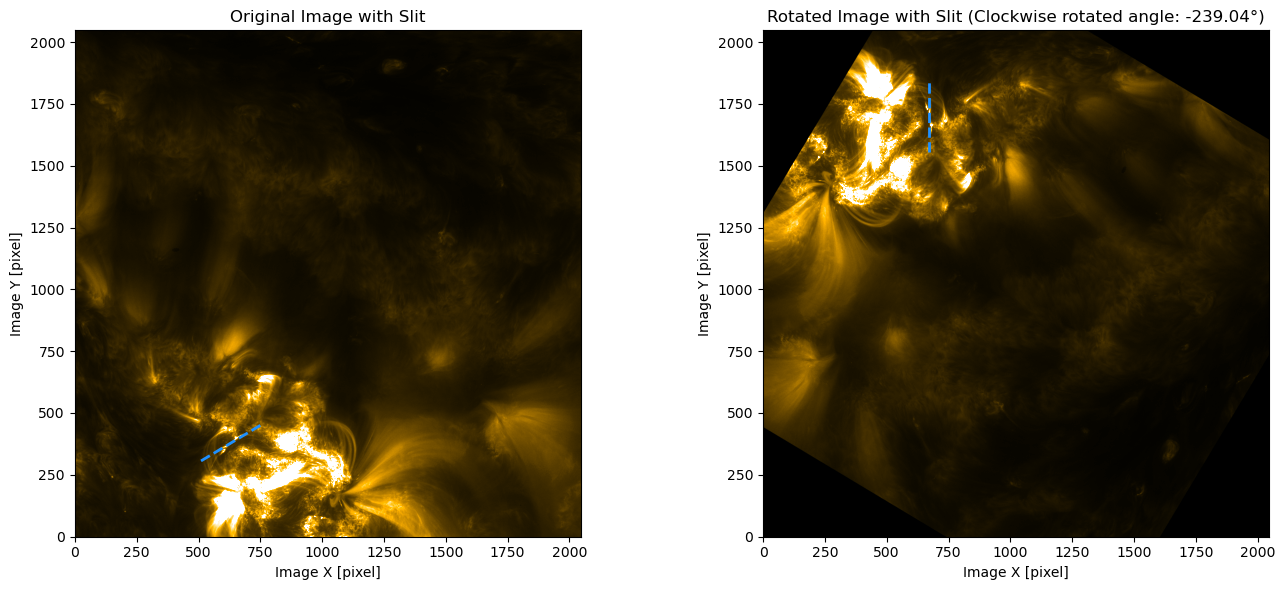

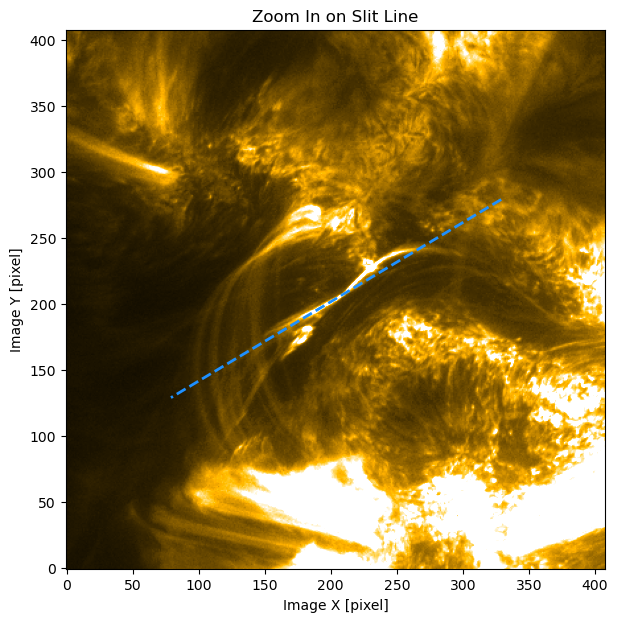

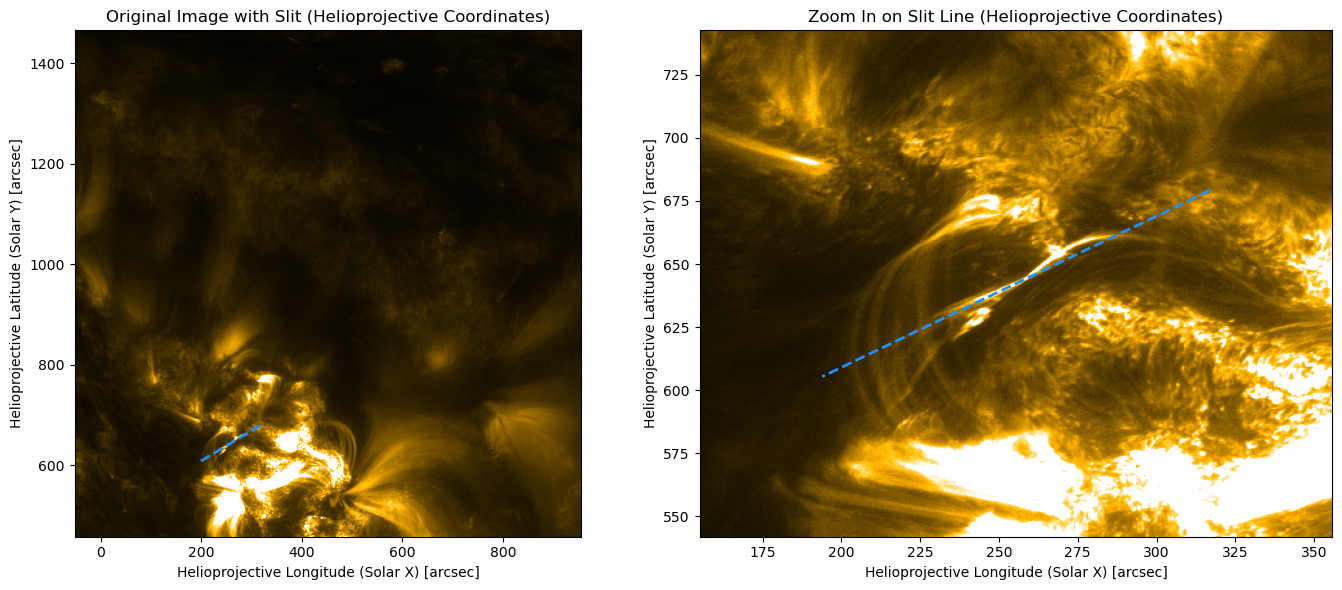

Output slice path already exists: /data2/pqf_SDO_SolO/SolO/slice_tests


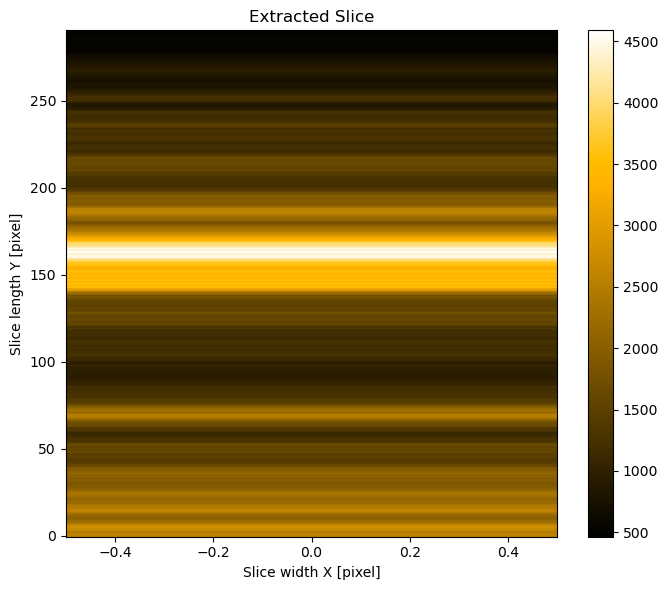

In [ ]:

# extract a single slice from a single fits file

import numpy as np
import sunpy.map
import matplotlib.pyplot as plt
from astropy.io import fits
from scipy.ndimage import rotate
import os
from astropy import units as u
from astropy.coordinates import SkyCoord


def read_fits(file_path):
    rsm = fits.open(file_path)
    data = rsm[1].data
    header = rsm[1].header
    rsm.close()
    return np.flipud(data), header

def pixel_to_heliocentric(x, y, sunpy_map):
    
    helioproj = [0.0, 0.0]
    helioproj[0] = sunpy_map.reference_coordinate.Tx.value + (x - sunpy_map.reference_pixel[0].value) * sunpy_map.scale[0].value
    helioproj[1] = sunpy_map.reference_coordinate.Ty.value + (y - sunpy_map.reference_pixel[1].value) * sunpy_map.scale[1].value

    return helioproj


def compute_rotation_angle(start, end):
    dy = start[1] - end[1]
    dx = end[0] - start[0]
    angle = np.arctan2(dy, dx) * 180 / np.pi
    # print(angle)
    # print(dx)
    if dx < 0:
        if angle < 0:
            return (np.abs(angle) - 90)
        else:
            return (- angle - 90)
    else:
        if angle < 0:
            return (- angle - 90)
        else:
            return (- angle - 90)

def rotate_point(x, y, angle, center):
    angle_rad = np.radians(angle)
    x_c, y_c = center
    x_new = (x - x_c) * np.cos(angle_rad) - (y - y_c) * np.sin(angle_rad) + x_c
    y_new = (x - x_c) * np.sin(angle_rad) + (y - y_c) * np.cos(angle_rad) + y_c
    return x_new, y_new

def compute_distance_and_comparison(start, end, data):
   
    center = (data.shape[1] / 2, data.shape[0] / 2)

    def calculate_distance(point, center):
        x, y = point
        x_c, y_c = center
        return np.sqrt((x - x_c)**2 + (y - y_c)**2)
    
    start_distance = calculate_distance(start, center)
    end_distance = calculate_distance(end, center)

    if start_distance > end_distance:
        return "Warning: Start point is farther from the image center than the end point. Please exchange the coords."
    elif start_distance < end_distance:
        return "Correct slit coord input. End point is farther from the image center than the start point."
    else:
        return "Please note that start point and end point are equidistant from the image center."

def rotate_image(data, angle):
    return rotate(data, angle, reshape=False)

def plot_images_and_slice(original_data, rotated_data, start, end, zoom_percent, vmax_factor, whether_high_dpi):
    # show original img and rotated img
    # draw the slit line on imgs
    # plt the zoom-in picture
    if whether_high_dpi:
        fig, axes = plt.subplots(1, 2, figsize=(14, 6), dpi=700)
    else:
        fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    
    vmin = 0
    vmax = original_data.mean() * vmax_factor

    # original img
    axes[0].imshow(original_data, origin='lower', cmap='solar orbiterhri_euv174', vmin=vmin, vmax=vmax)
    axes[0].set_title('Original Image with Slit')
    axes[0].set_xlabel('Image X [pixel]')
    axes[0].set_ylabel('Image Y [pixel]')
    axes[0].plot([start[0], end[0]], [start[1], end[1]], color='#1E90FF', lw=2, linestyle='--')
    
    # rotated img, to make the slit upright and be (mostly) in the upper part
    angle = compute_rotation_angle(start, end)
    center = (original_data.shape[1] / 2, original_data.shape[0] / 2)
    start_rotated = rotate_point(start[0], start[1], -angle, center)
    end_rotated = rotate_point(end[0], end[1], -angle, center)
    
    axes[1].imshow(rotated_data, origin='lower', cmap='solar orbiterhri_euv174', vmin=vmin, vmax=vmax)
    axes[1].set_title(f'Rotated Image with Slit (Clockwise rotated angle: {angle:.2f}°)')
    axes[1].set_xlabel('Image X [pixel]')
    axes[1].set_ylabel('Image Y [pixel]')
    axes[1].plot([start_rotated[0], end_rotated[0]], [start_rotated[1], end_rotated[1]], color='#1E90FF', lw=2, linestyle='--')

    plt.tight_layout()
    plt.show()

    # Zoom-In img
    line_length = np.linalg.norm([start_rotated[0] - end_rotated[0], start_rotated[1] - end_rotated[1]])
    zoom_margin = line_length * zoom_percent
    center_x = (start[0] + end[0]) / 2
    center_y = (start[1] + end[1]) / 2

    half_size = int(zoom_margin)
    x_min = max(0, int(center_x - half_size))
    x_max = min(original_data.shape[1], int(center_x + half_size))
    y_min = max(0, int(center_y - half_size))
    y_max = min(original_data.shape[0], int(center_y + half_size))

    zoom_in_data = original_data[y_min:y_max, x_min:x_max]

    start_zoom_pix = [0.0, 0.0]
    end_zoom_pix = [0.0, 0.0]
    start_zoom_pix[0] = x_min
    start_zoom_pix[1] = y_min
    end_zoom_pix[0] = x_max
    end_zoom_pix[1] = y_max
    
    fig, ax = plt.subplots(figsize=(7, 7))
    ax.imshow(zoom_in_data, origin='lower', cmap='solar orbiterhri_euv174', vmin=vmin, vmax=vmax)
    ax.set_xlabel('Image X [pixel]')
    ax.set_ylabel('Image Y [pixel]')
    ax.set_title('Zoom In on Slit Line')
    
    # plt the slit on zoom-in img
    start_zoomed = (start[0] - x_min, start[1] - y_min)
    end_zoomed = (end[0] - x_min, end[1] - y_min)
    ax.plot([start_zoomed[0], end_zoomed[0]], [start_zoomed[1], end_zoomed[1]], color='#1E90FF', lw=2, linestyle='--')
    
    plt.show()

    return start_zoom_pix, end_zoom_pix

def plot_heliocentric_images(data, sunpy_map, start, end, zoom_percent, start_zoom_pix, end_zoom_pix, vmax_factor, whether_high_dpi):
    # show the plots again in heliocentric coords
    if whether_high_dpi:
        fig, axes = plt.subplots(1, 2, figsize=(14, 6), dpi=700)
    else:
        fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    

    vmin = 0
    vmax = data.mean() * vmax_factor   # should be modified

    # original
    start_heliocentric = pixel_to_heliocentric(start[0], start[1], sunpy_map)
    end_heliocentric = pixel_to_heliocentric(end[0], end[1], sunpy_map)
    
    # compute the helioproj. coord range
    x_min = sunpy_map.reference_coordinate.Tx.value - (sunpy_map.reference_pixel[0].value * sunpy_map.scale[0].value)
    x_max = sunpy_map.reference_coordinate.Tx.value + ((sunpy_map.data.shape[0] - sunpy_map.reference_pixel[0].value) * sunpy_map.scale[0].value)
    y_min = sunpy_map.reference_coordinate.Ty.value - (sunpy_map.reference_pixel[1].value * sunpy_map.scale[1].value)
    y_max = sunpy_map.reference_coordinate.Ty.value + ((sunpy_map.data.shape[1] - sunpy_map.reference_pixel[1].value) * sunpy_map.scale[1].value) 

    extent = [x_min, x_max, y_min, y_max]
    axes[0].imshow(data, origin='lower', cmap='solar orbiterhri_euv174', vmin=vmin, vmax=vmax, extent=extent)
    axes[0].set_title('Original Image with Slit (Helioprojective Coordinates)')
    axes[0].set_xlabel('Helioprojective Longitude (Solar X) [arcsec]')
    axes[0].set_ylabel('Helioprojective Latitude (Solar Y) [arcsec]')
    axes[0].plot([start_heliocentric[0], end_heliocentric[0]], 
                 [start_heliocentric[1], end_heliocentric[1]], color='#1E90FF', lw=2, linestyle='--')


    # Zoom-In 

    line_length = np.linalg.norm(np.array(start_heliocentric) - np.array(end_heliocentric))
    zoom_margin = line_length * zoom_percent
    center_x = (start_heliocentric[0] + end_heliocentric[0]) / 2
    center_y = (start_heliocentric[1] + end_heliocentric[1]) / 2

    x_min_zoom = center_x - zoom_margin
    x_max_zoom = center_x + zoom_margin
    y_min_zoom = center_y - zoom_margin
    y_max_zoom = center_y + zoom_margin

    zoom_in_extent = [x_min_zoom, x_max_zoom, y_min_zoom, y_max_zoom]

    # data itself is embeded in pix unit, although can be shown in helioproj. unit in default,
    # so when cut out the zoom-in part of image, one should use pix unit coord to cut
    zoom_in_data = data[int(start_zoom_pix[1]):int(end_zoom_pix[1]), int(start_zoom_pix[0]):int(end_zoom_pix[0])]

    axes[1].imshow(zoom_in_data, origin='lower', cmap='solar orbiterhri_euv174', vmin=vmin, vmax=vmax, extent=zoom_in_extent, aspect='auto')
    axes[1].set_title('Zoom In on Slit Line (Helioprojective Coordinates)')
    axes[1].set_xlabel('Helioprojective Longitude (Solar X) [arcsec]')
    axes[1].set_ylabel('Helioprojective Latitude (Solar Y) [arcsec]')
    axes[1].plot([start_heliocentric[0], end_heliocentric[0]], 
                 [start_heliocentric[1], end_heliocentric[1]], color='#1E90FF', lw=2, linestyle='--')

   
    plt.tight_layout()
    plt.show()
    return vmin, vmax

def extract_slice(data, start, end, delta_pix, center, angle, vmin, vmax):
   
    data = np.clip(data, vmin, vmax)

    start_rotated = rotate_point(start[0], start[1], -angle, center)
    end_rotated = rotate_point(end[0], end[1], -angle, center)
    
    # compute the direction of slit
    dy = end_rotated[1] - start_rotated[1]
    dx = end_rotated[0] - start_rotated[0]
    
    # create a pixel stripe along the slit with width of delta_pix
    # compute the slope of slit line, get coord of each point on the slit line
    # extract the stripe
    perp_slope = -dx / dy if dy != 0 else 0  
    
    slice_pixels = []
    for t in np.linspace(0, 1, num=int(np.linalg.norm([dx, dy]))):  # interpolation along the slit 
        x = int(start_rotated[0] + t * dx)
        y = int(start_rotated[1] + t * dy)
        
        for i in range(-delta_pix//2, delta_pix//2):
            x_offset = int(i * np.cos(np.arctan(perp_slope)))
            y_offset = int(i * np.sin(np.arctan(perp_slope)))
            if 0 <= y + y_offset < data.shape[0] and 0 <= x + x_offset < data.shape[1]:
                slice_pixels.append(data[y + y_offset, x + x_offset])
    
    return np.array(slice_pixels).reshape(-1, delta_pix)

def save_and_show_slice(slice_data, output_dir, file_name, fits_path):

    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    # add the name of original fits file to the slice file name
    fits_name = os.path.basename(fits_path).replace('.fits', '')

    file_name = f"{fits_name}_{file_name}"

    fig, ax = plt.subplots(figsize=(7, 6))

    im = ax.imshow(slice_data, cmap='solar orbiterhri_euv174', origin='lower', aspect='auto')
    ax.set_title('Extracted Slice (temporarily widened for visibility)')
    ax.set_xlabel('Slice width X [pixel]')
    ax.set_ylabel('Slice length Y [pixel]')
    fig.colorbar(im, ax=ax)  

    plt.tight_layout()
    plt.show()

    output_path = os.path.join(output_dir, file_name)
    plt.imsave(output_path, np.flipud(slice_data), cmap='afmhot')

def process_and_extract_slice(data, start_point, end_point, delta_pix, output_dir, vmin, vmax):
    # compute the rotation angle   
    # extract slice
    # save the slice

    angle = compute_rotation_angle(start_point, end_point)
    center = (data.shape[1] / 2, data.shape[0] / 2)

    slice_data = extract_slice(data, start_point, end_point, delta_pix, center, angle, vmin, vmax)
    
    file_name = f"slice_{start_point[0]}_{start_point[1]}_{end_point[0]}_{end_point[1]}.png"
    save_and_show_slice(slice_data, output_dir, file_name, file_path)

#———————————————————————————————————————————————————————————————————————————————————————————————————————————————————————
# slit parameters input
# start point coord must be nearer than end point to the image centre
file_path = "/data2/pqf_SDO_SolO/data_SolO/test_downloads/EUI-HRIEUV174-IMAGE_2023-04-23 11:55:00_to_2023-04-23 12:15:00/solo_L2_eui-hrieuv174-image_20230423T120500191_V01.fits"

start_point = (750, 450)
end_point =  (500, 300)  

# if need high quality img output, make this 'True', and when showing the imgs,
# dpi will be 700 for original & rotated img in pix unit, and original & zoom-in img in helioproj. unit
whether_high_dpi = False   

vmax_factor = 7    # determine vmax to be how many times the average of data cube
zoom_percent = 0.7
delta_pix = 1   # the width of slice (in pix)
output_each_slice_dir = "/data2/pqf_SDO_SolO/SolO/slice_tests"  
#———————————————————————————————————————————————————————————————————————————————————————————————————————————————————————

data_raw, header = read_fits(file_path)
sunpy_map = sunpy.map.Map(file_path)
data = sunpy_map.data
# check if start point coord is nearer than end point to the image centre
result = compute_distance_and_comparison(start_point, end_point, data)
print(result)

angle = compute_rotation_angle(start_point, end_point)
print(f"Rotated {angle}° in clockwise to make the slit upright.")

rotated_data = rotate_image(data, angle)

start_zoom_pix, end_zoom_pix = plot_images_and_slice(data, rotated_data, start_point, end_point, zoom_percent, vmax_factor, whether_high_dpi)
vmin, vmax = plot_heliocentric_images(data, sunpy_map, start_point, end_point, zoom_percent, start_zoom_pix, end_zoom_pix, vmax_factor, whether_high_dpi)

# extracte and save slice png
if not os.path.exists(output_each_slice_dir):
    os.makedirs(output_each_slice_dir)
    print(f"Created output slice dir: {output_each_slice_dir}")
else:
    print(f"Output slice path already exists: {output_each_slice_dir}")

process_and_extract_slice(rotated_data, start_point, end_point, delta_pix, output_each_slice_dir, vmin, vmax)


# print("CUNIT1:", header.get('CUNIT1', 'Unknown'))
# print("CUNIT2:", header.get('CUNIT2', 'Unknown'))

# saved file_name = f"slice_{start_point[0]}_{start_point[1]}_{end_point[0]}_{end_point[1]}.png"

